In [1]:
import os
import math
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [2]:
root_dir = os.getcwd()
data_path = f'{root_dir}\db_28_2_excel'

# Approach

 To create a definition for jobs that are analytical, I wanted to focus primarily on the descriptions of positions in the `Occupation Data` Excel sheet, as I would be able to focus on these descriptions when classifying specific positions as analytical.
 
However, in order to do so, I had to create a list of common terms for analytical positions. Thorough research allowed me to compile a list that I was able to use to filter out the analytical jobs through this definition.

In [3]:
df_occupations = pd.read_excel(f'{data_path}\Occupation Data.xlsx')
df_abilities = pd.read_excel(f'{data_path}\Abilities.xlsx')
df_tech = pd.read_excel(f'{data_path}\Technology Skills.xlsx')

In [4]:
ps = PorterStemmer()
nltk.download('stopwords')
stopwords = stopwords.words('english')

def process_text(text):
    """process text for analysis"""
    # lowercase the text
    text_lower = text.lower()
    
    # remove punctuation
    text_no_punc = ''.join([char for char in text_lower if char not in punctuation])
    
    # tokenize and stem the words
    words = word_tokenize(text_no_punc)
    key_words = [word for word in words if word not in stopwords]
    stemmed_words = [ps.stem(word) for word in key_words]

    # combine back into one string 
    stemmed = ' '.join(stemmed_words)
    
    return stemmed

In [15]:
# define key terms 
terms = [
    'data', 
    'statistical', 
    'quantitative', 
    'predictive', 
    'business intelligence', 
    'problem-solving',
    'attention to detail', 
    'project management', 
    'domain knowledge', 
    'continuous learning', 
    'analyst', 
    'decision-making', 
    'pattern recognition', 
    'modeling', 
    'metrics', 
    'insights', 
    'correlation', 
    'causation',  
    'insight', 
    'validation', 
    'experimentation', 
    'causality', 
    'forecasting', 
    'summary', 
    'recommendation', 
    'comparison'
]

terms = [process_text(term) for term in terms]

In [6]:
# create a new column of with the cleaned descriptions
df_occupations['Description (clean)'] = df_occupations['Description'].apply(process_text)

# filter the occupation data df for only descriptions that contain the key terms
filtered_df = df_occupations[df_occupations['Description (clean)'].str.contains('|'.join(terms), case=False)]
filtered_df.head()

,O*NET-SOC Code,Title,Description,Description (clean)
6,11-2022.00,Sales Managers,"Plan, direct, or coordinate the actual distrib...",plan direct coordin actual distribut movement ...
12,11-3021.00,Computer and Information Systems Managers,"Plan, direct, or coordinate activities in such...",plan direct coordin activ field electron data ...
16,11-3051.00,Industrial Production Managers,"Plan, direct, or coordinate the work activitie...",plan direct coordin work activ resourc necessa...
24,11-3071.04,Supply Chain Managers,"Direct or coordinate production, purchasing, w...",direct coordin product purchas wareh distribut...
41,11-9121.00,Natural Sciences Managers,"Plan, direct, or coordinate activities in such...",plan direct coordin activ field life scienc ph...


In [7]:
""" 
    When non-analytical positions make their way into the filtered dataframe,
    I used the following code to find which search term was contained in its 
    description. I would then remove the term from the terms list because it 
    was too broad.
"""
desc = """
Play parts in stage, television, radio, video, or film productions, or other settings for entertainment, information, or instruction. Interpret serious or comic role by speech, gesture, and body movement to entertain or inform audience. May dance and sing.
""" # this is the description for an actor, which I would not consider analytical

for term in terms:
    if term in process_text(desc):
        print(term)

# Data Analysis

In [8]:
# find the O*NET SOC Code for analytical jobs
analytical_codes = filtered_df['O*NET-SOC Code']

#### Technology Skills

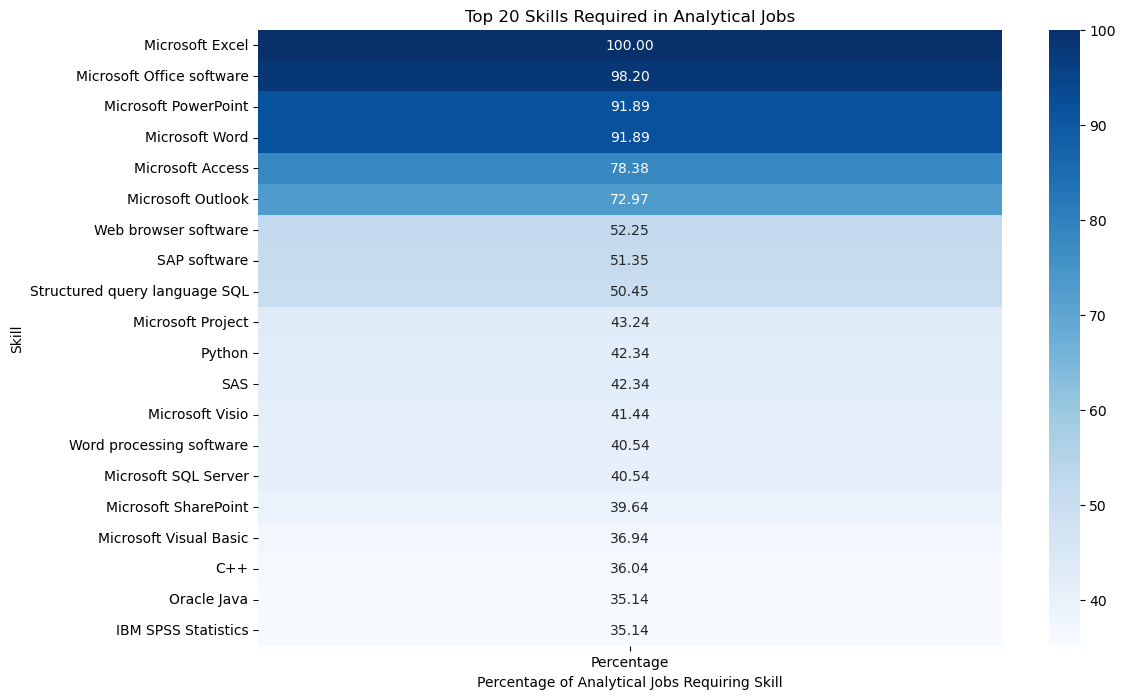

In [26]:
# filter the technoloy skills dataframe for the technical positions
df_tech_analytical = df_tech[df_tech['O*NET-SOC Code'].isin(analytical_codes)]

# calculate the total number of analytical jobs
job_count = len(df_tech_analytical.groupby('O*NET-SOC Code'))

# rename exmample column to skill, count the number of jobs that require each skill
df_tech_analytical = df_tech_analytical.rename(columns={'Example': 'Skill'})
df_tech_counts = df_tech_analytical.groupby('Skill').size().reset_index(name='Count')

# calculate the percentage of analytical jobs that require each skill and get the top 20 most required skills
df_tech_counts['Percentage'] = round((df_tech_counts['Count'] / job_count)  * 100, 2)
top_20 = df_tech_counts.nlargest(20, 'Percentage')

# create pivot table
t20_pivot = top_20.pivot_table(index='Skill', values='Percentage')
# re-sort
t20_pivot = t20_pivot.sort_values(by='Percentage', ascending=False)

# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(t20_pivot, cmap='Blues', annot=True, fmt=".2f")

# labels
plt.title('Top 20 Skills Required in Analytical Jobs')
plt.xlabel('Percentage of Analytical Jobs Requiring Skill')
plt.ylabel('Skill')
plt.show()

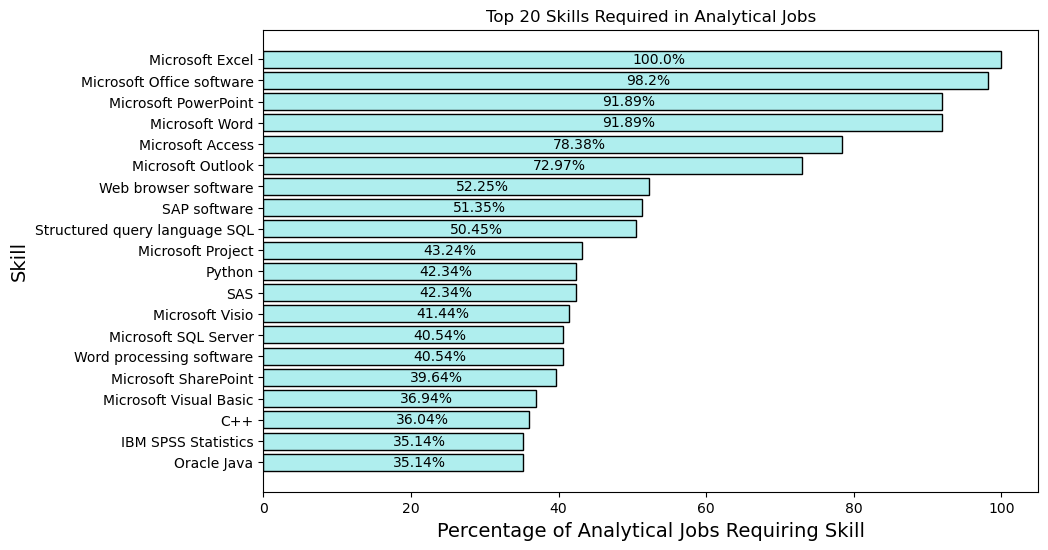

In [10]:
# plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.barh(top_20['Skill'], top_20['Percentage'], color='paleturquoise', edgecolor='black')
for bar in bars:
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}%', 
             va='center', ha='left', color='black')

# labels
plt.xlabel('Percentage of Analytical Jobs Requiring Skill', fontsize=14)  
plt.ylabel('Skill', fontsize=14)
plt.title('Top 20 Skills Required in Analytical Jobs')
plt.gca().invert_yaxis()  # highest percentage at the top
plt.show()

#### General Skills

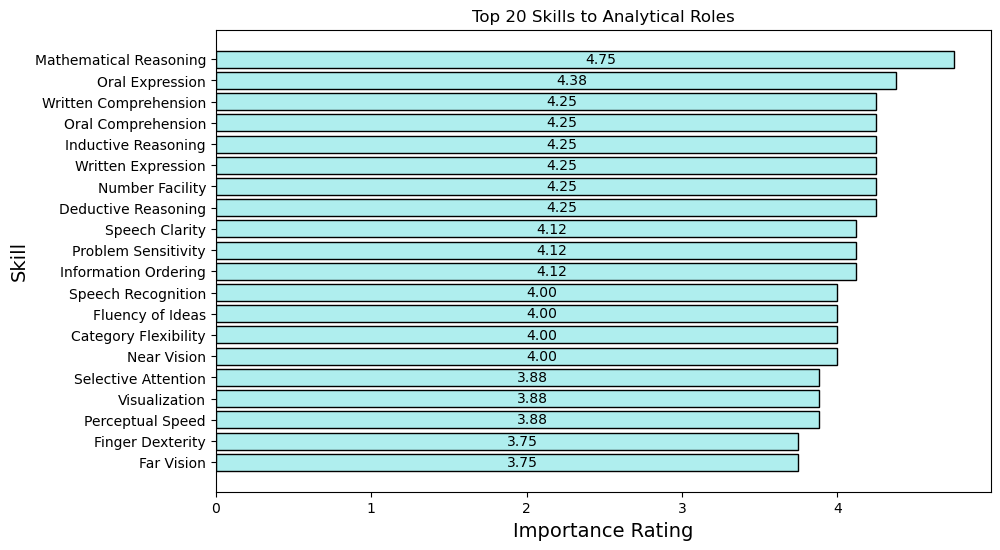

In [11]:
# filter the abilities dataframe for the technical positions
df_abilities_analytical = df_abilities[df_abilities['O*NET-SOC Code'].isin(analytical_codes)]

# filter the importances out and sort
df_abilities_importance = df_abilities_analytical[df_abilities_analytical['Scale ID'] == 'IM']
sorted_importance = df_abilities_importance.sort_values(by='Data Value', ascending=False)

# extract the top 20 most important skills 
top_importances = sorted_importance.drop_duplicates(subset='Element Name')
top_20 = top_importances.head(20)

# plot the top 20 most important skills
plt.figure(figsize=(10, 6))
bars = plt.barh(top_20['Element Name'], top_20['Data Value'], color='paleturquoise', edgecolor='black')
for bar in bars:
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black')
    
# labels
plt.xlabel('Importance Rating', fontsize=14)
plt.ylabel('Skill', fontsize=14)
plt.title('Top 20 Skills to Analytical Roles')
plt.gca().invert_yaxis()  # put highest values on top
plt.show()